El objetivo de el trabajo es descubrir si hay una releación entre el precio del GNC y el precio de los materiales de construcción en Rosario. La hipótesis es que a medida que aumente el precio del GNC aumentaran los gastos de transporte por lo que también aumentaran los precios de los materiales.

Para analizar esto se tomaron datos desde enero de 2019 hasta abril del 2023.

# Exploración de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Los datasets se obutiveron de las siguientes fuentes:
- [Precios gas natural](http://datos.energia.gob.ar/dataset/precios-de-gas-natural)
- [Precios materiales](https://datosabiertos.rosario.gob.ar/dataset/%C3%ADndices-de-precios-de-materiales-de-la-construcci%C3%B3n)

In [2]:
precios_gas        = pd.read_csv('datasets/precios-gas-natural.csv')
precios_materiales = pd.read_csv('datasets/precios-materiales-construccion.csv')

In [3]:
precios_materiales.rename(
    columns={
        'Año': 'anio',
        'Mes': 'mes',
        'id_Rubro': 'id_rubro',
        'Rubro': 'rubro',
        'variación mensual': 'variacion_mensual'
    },
    inplace=True
)   

Solo se van a analizar el total de los precios, sin importar el tipo de contrato

In [4]:
precios_gas = \
    precios_gas[precios_gas.contrato == 'TOTAL']

Se separa por cuenca.

In [5]:
santa_cruz = precios_gas[precios_gas.cuenca == 'Austral Santa Cruz']
santa_cruz.Name = 'Austral Santa Cruz'

tierra_del_fuego = precios_gas[precios_gas.cuenca == 'Austral Tierra del Fuego']
tierra_del_fuego.Name = 'Austral tierra del Fuego'

golfo_san_jorge = precios_gas[precios_gas.cuenca == 'Golfo de San Jorge']
golfo_san_jorge.Name = 'Golfo de San Jorge'

neuquina = precios_gas[precios_gas.cuenca == 'Neuquina']
neuquina.Name = 'Neuquina'

noroeste = precios_gas[precios_gas.cuenca == 'Noroeste']
noroeste.Name = 'Noroeste'

cuencas = [
    santa_cruz, tierra_del_fuego,
    golfo_san_jorge, neuquina,
    noroeste
]

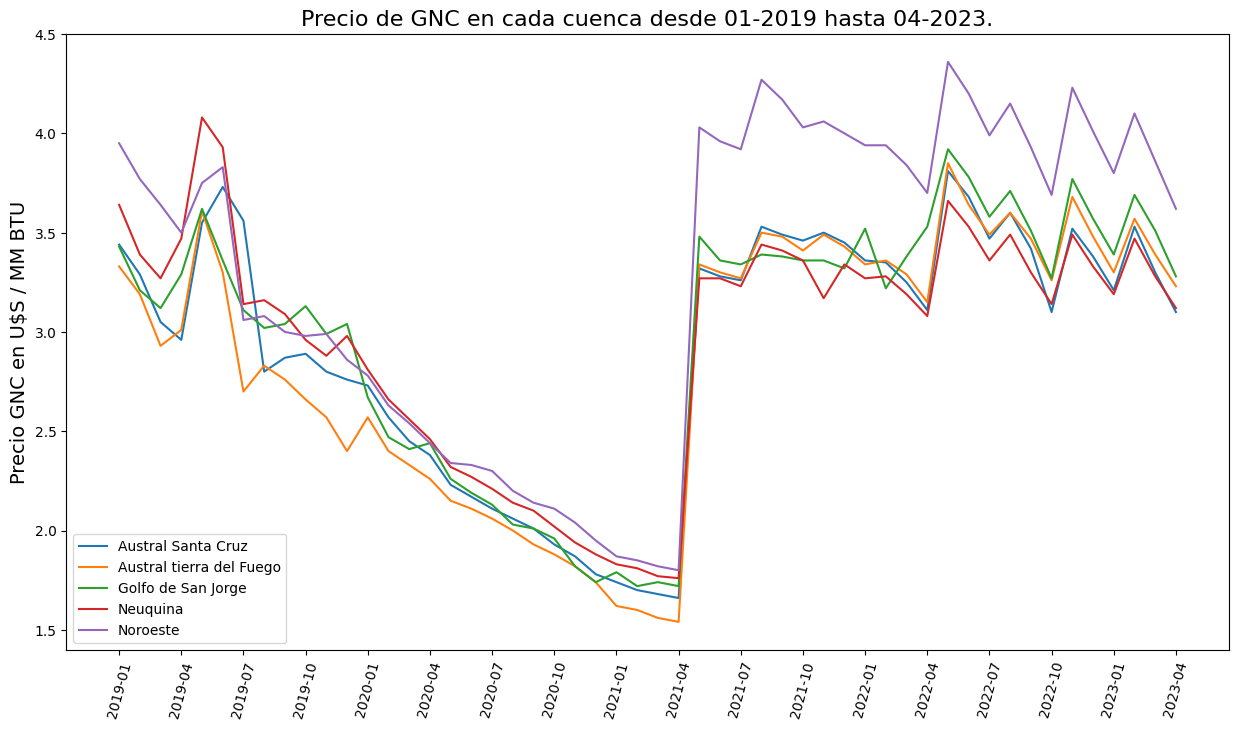

In [6]:
plt.figure(figsize=(15, 8))

for cuenca in cuencas:
    plt.plot(
        cuenca.indice_tiempo,
        cuenca.precio_gnc,
        label=cuenca.Name
    )

plt.xticks(np.arange(0, 52, 3), rotation=75)
plt.title(
    'Precio de GNC en cada cuenca desde 01-2019 hasta 04-2023.',
    fontsize=16
)

plt.ylabel(
    'Precio GNC en U$S / MM BTU',
    fontsize=14
)

plt.legend()

In [7]:
exportaciones_promedio = []

for cuenca in cuencas:
    exportaciones_promedio.append(
        (
            cuenca.Name,
            round(cuenca.precio_expo.mean(), 2)
        )
    )
    
exportaciones_promedio.sort(key=lambda tupla: tupla[1], reverse=True)

Precio promedio para la exportación de cada cuenca:

In [8]:
for val in exportaciones_promedio:
    print(f'{val[0]:<25} {val[1]}')

Neuquina                  4.59
Austral Santa Cruz        2.52
Austral tierra del Fuego  1.56
Golfo de San Jorge        0.88
Noroeste                  0.14


Naturalmente la cuenca Neuquina tiene el mayor precio para las exportación ya que ahí se encuentra Vaca Muerta.

Text(0.5, 1.0, 'Relación entre el precio de GNC y el precio de exportación')

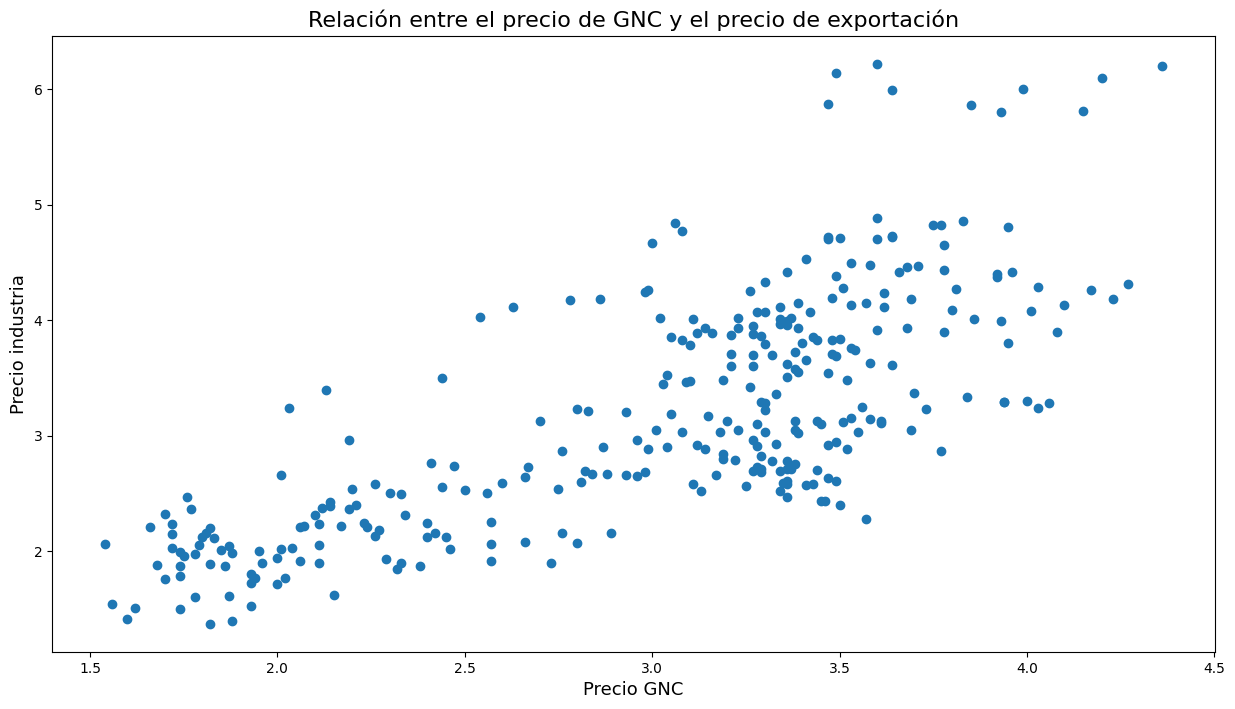

In [9]:
plt.figure(figsize=(15, 8))

cuencas_total = \
    precios_gas[precios_gas.contrato == 'TOTAL']

plt.scatter(cuencas_total.precio_gnc,
            cuencas_total.precio_industria)

plt.xlabel(
    'Precio GNC',
    fontsize=13
)

plt.ylabel(
    'Precio industria',
    fontsize=13
)

plt.title(
    'Relación entre el precio de GNC y el precio de exportación',
    fontsize=16
)

Podemos ver en el gráfico que hay una correlación entre el precio de GNC y el precio de venta a la industria. Tiene sentido que esto sea así porque ademas de los gastos de industria las empresas también tienen los gastos de transporte para la logística.

In [10]:
precios_materiales.anio = precios_materiales.anio.astype(str)
precios_materiales.mes = precios_materiales.mes.astype(str)

Calculamos cuál fue el porcentaje de aumento del precio de cada material desde 2019 hasta 2023.

In [11]:
precios_materiales['indice_tiempo'] = \
    precios_materiales.anio + '-' + precios_materiales.mes.str.zfill(2)

In [12]:
id_rubros = precios_materiales.id_rubro.unique()

In [13]:
porcentajes = list()

for rubro in id_rubros:
    precio_inicial = \
        precios_materiales[precios_materiales.id_rubro == rubro].iloc[0].indice
    
    precio_final = \
        precios_materiales[precios_materiales.id_rubro == rubro].iloc[-1].indice
    
    nombre_material = \
        precios_materiales[precios_materiales.id_rubro == rubro].iloc[0].rubro
    
    rango = precio_final - precio_inicial
    
    porcentajes.append((nombre_material, round((rango / precio_inicial) * 100, 2)))

In [14]:
porcentajes.sort(key=lambda tupla: tupla[1])

Text(0, 0.5, 'Aumento de precio en %')

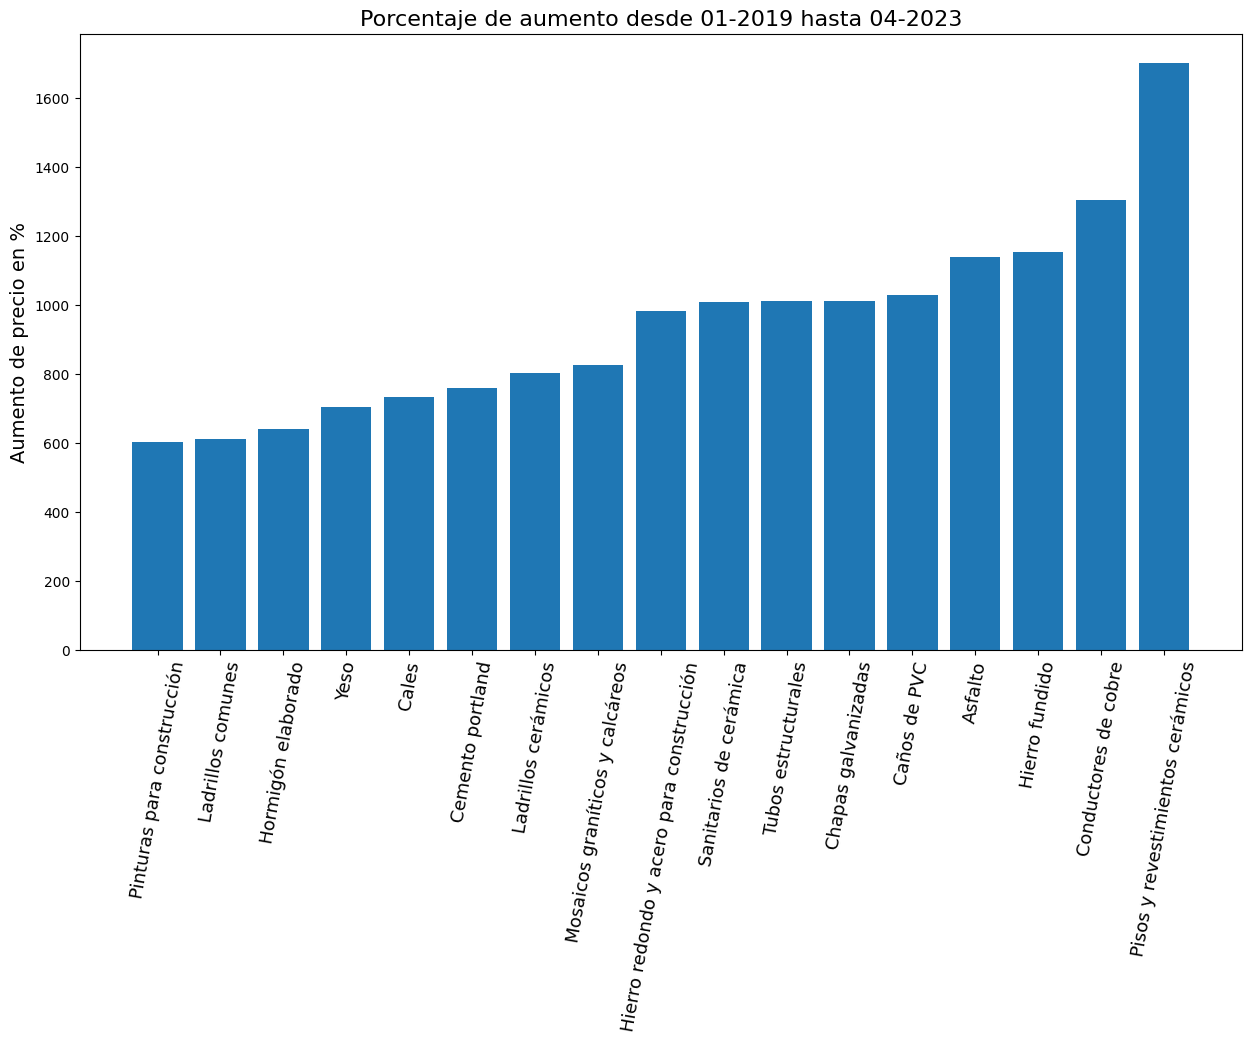

In [15]:
plt.figure(figsize=(15, 8))

plt.bar(
    [tupla[0] for tupla in porcentajes],
    [tupla[1] for tupla in porcentajes]
)

plt.xticks(
    rotation=80,
    fontsize=13
)

plt.title(
    'Porcentaje de aumento desde 01-2019 hasta 04-2023',
    fontsize=16
)

plt.ylabel('Aumento de precio en %', fontsize=14)

Es interesante ver que los pisos y revestimientos cerámicos tuvieron el aumento más grande de todos. Las otras categorías también tuvieron un gran aumento pero no hay un salto tan grande entre estos materiales. Esto se deba a que probablemente los pisos y revestimientos sea caros de fabricar y no tengan tanta demanda como otros tipos de materiales más esenciales.

## Unión de los datasets

Los datos solo se unen con la cuenca Neuquina porque de las disponibles en el dataset es la más cercana geograficamente a Rosario, así que es muy probable que los distribuidores de GNC de la ciudad compren el gas natural de esta cuenca.

In [16]:
precios = \
    pd.merge(
        left=neuquina,
        right=precios_materiales,
        how='inner',
        left_on='indice_tiempo',
        right_on='indice_tiempo'
    )

In [17]:
precios.drop(
    columns={
        'anio_x',
        'mes_x',
        'anio_y',
        'mes_y'
    },
    inplace=True
)

Vamos a comparar el precio del GNC con dos materiales, el que más aumento de precio (`id_rubro = 14`) y el que menos aumentó (`id_rubro = 13`).

In [18]:
precios_ceramicos = precios[precios.id_rubro == 14]
precios_pinturas  = precios[precios.id_rubro == 13]

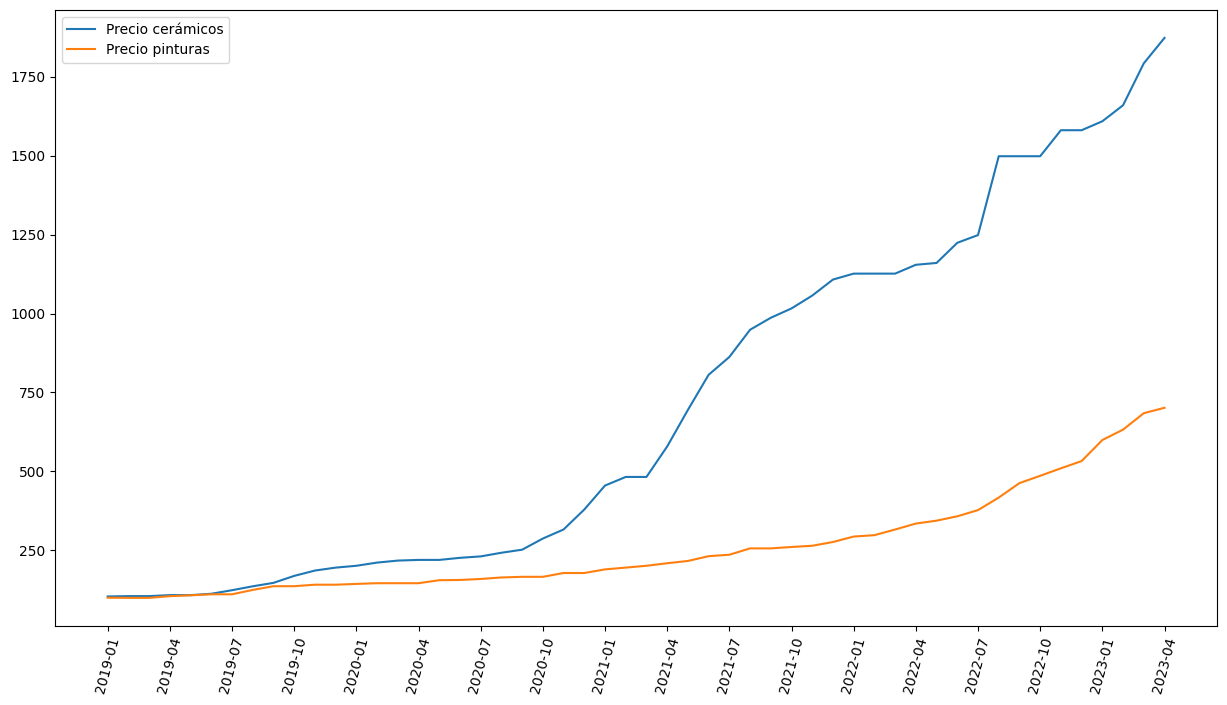

In [19]:
plt.figure(figsize=(15, 8))

plt.plot(
    precios_ceramicos.indice_tiempo,
    precios_ceramicos.indice,
    label='Precio cerámicos'
)

plt.plot(
    precios_pinturas.indice_tiempo,
    precios_pinturas.indice,
    label='Precio pinturas'
)

plt.xticks(np.arange(0, 52, 3), rotation=75)

plt.legend()

Ambos materiales tienen una tendencia creciente en estos últimos cuatro años. Sin embargo a partir de abril de 2021 el precio de los cerámicos comenzó a aumentar su precio a un nivel más rápido, esto coincide con el aumento significativo que tuvo el precio de venta del GNC.

Estos podría relacionarse a que es usual que las placas para los pisos y revestimienos cerámicos suelen romperse durante el transporte, por esto en general se envían y se producen de más para reemplazar los defectuosos. Esto no ocurre en el caso de la pintura que está bien protegida y no tiene problemas durante su transporte.